## 군집 분석 - 비지도 학습을 통해 어떤 고객층이 있는 지 확인해보고 특성을 확인 해보자

In [44]:
# 공통으로 사용되는 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 비지도 학습 - 군집화에 사용되는 라이브러리
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# 비지도 학습 - 연관성 분석에 사용되는 라이브러리
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [45]:
# 데이터 가져오기
mall_df = pd.read_csv("Mall_Customers.csv")

# 데이터 확인 - head 실습
mall_df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 컬럼 
- 1. CustomerID : 고객ID
- 2. Genre : 성별
- 3. Age : 나이
- 4. Annual Income (k$) : 연소득
- 5. Spending Score (1-100) : 소비 점수

#### 데이터 분포 확인

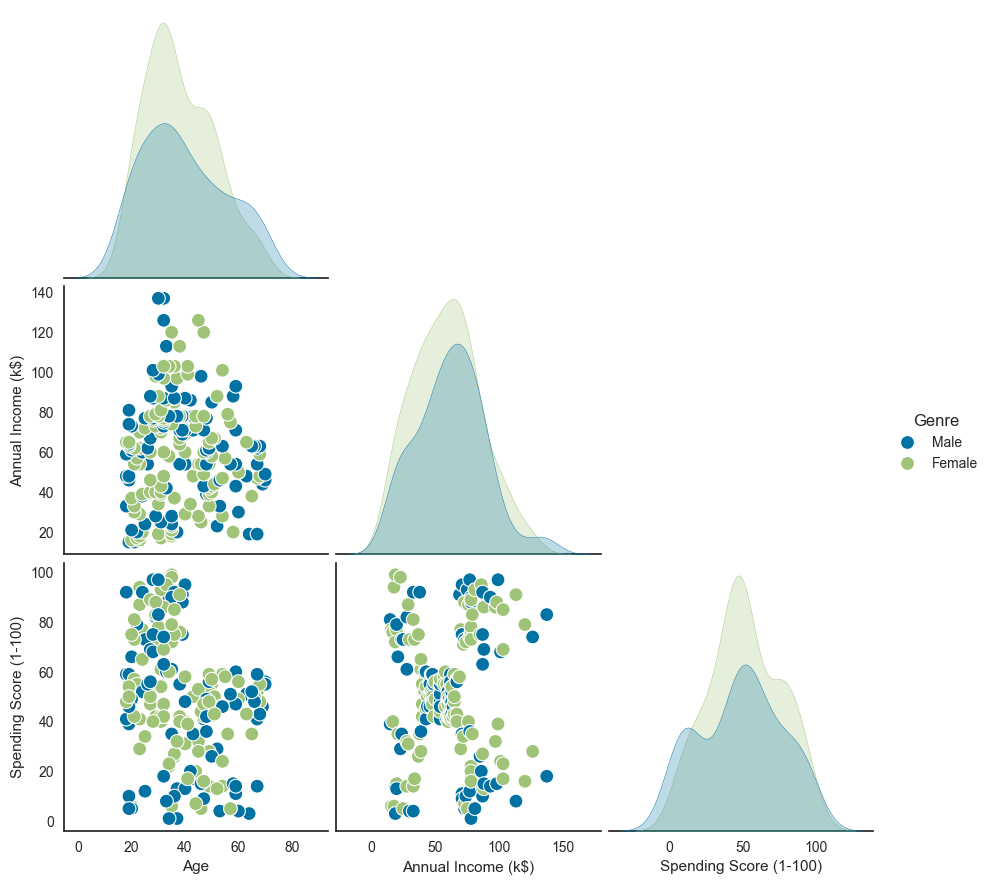

In [46]:
# 어떤 방식으로 고객별로 군집화를 시킬 수 있을 지 확인해보자!

# 산점도 항(렬 시각화
# ID 칼럼 제거
mall_pair_df = mall_df.drop("CustomerID", axis=1)

sns.set_style("ticks")
sns.pairplot(
    mall_pair_df,
    diag_kind="kde",  # 상관계수가 1 이면 분포로 표시
    hue="Genre",
    corner=True,
    height=3,
    plot_kws={"s": 100},
)
plt.show()


#### 데이터 전처리

In [47]:
from sklearn.preprocessing import MinMaxScaler

# 범주형 변수 전처리 - 원핫 인코딩
preprocess_mall_df = pd.get_dummies(mall_pair_df, columns=["Genre"], drop_first=True)

print(preprocess_mall_df.head())

# 데이터 정규화 적용 (MinMaxScaler)
MinMaxScaler = MinMaxScaler()
mall_minmax_df = MinMaxScaler.fit_transform(preprocess_mall_df)

# 컬럼명 결합
mall_minmax_df = pd.DataFrame(data=mall_minmax_df, columns=preprocess_mall_df.columns)

# 데이터 확인하기
print(mall_minmax_df.head())

   Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male
0   19                  15                      39        True
1   21                  15                      81        True
2   20                  16                       6       False
3   23                  16                      77       False
4   31                  17                      40       False
        Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male
0  0.019231            0.000000                0.387755         1.0
1  0.057692            0.000000                0.816327         1.0
2  0.038462            0.008197                0.051020         0.0
3  0.096154            0.008197                0.775510         0.0
4  0.250000            0.016393                0.397959         0.0


In [48]:
from sklearn.cluster import KMeans

# k-means 클러스터링 모델 생성
kmeans_model = KMeans(
    init="k-means++", n_clusters=3, n_init=10, max_iter=300, random_state=37
)

kmeans_model.fit(mall_minmax_df)

# 최저 SSE 값
print(kmeans_model.inertia_)

# 각 군집의 중심점 좌표 확인
print(kmeans_model.cluster_centers_)

# 반복 횟수
print(kmeans_model.n_iter_)

29.552857611943857
[[1.97115385e-01 3.85245902e-01 7.21173469e-01 1.00000000e+00]
 [3.86504121e-01 3.62704918e-01 5.15579446e-01 4.44089210e-16]
 [6.04567308e-01 3.88661202e-01 2.87840136e-01 1.00000000e+00]]
10


#### K는 몇개일까요?

<Axes: >

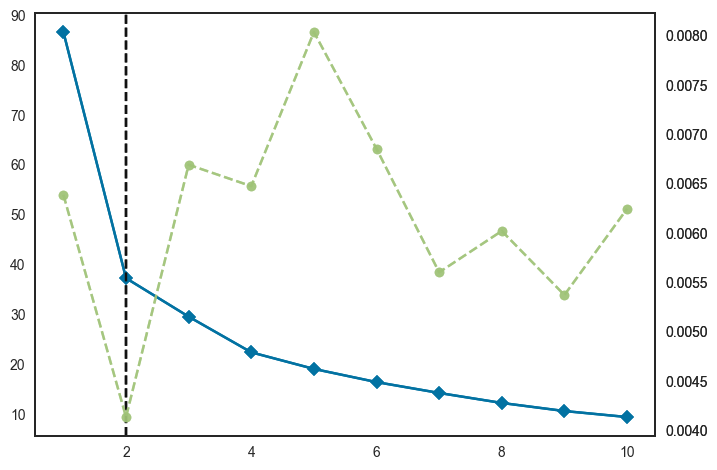

In [49]:
# Elbow Method
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Elbow Chart 그리기
Elbow_Chart = KElbowVisualizer(kmeans_model, k=(1, 11))
Elbow_Chart.fit(mall_minmax_df)
Elbow_Chart.draw()

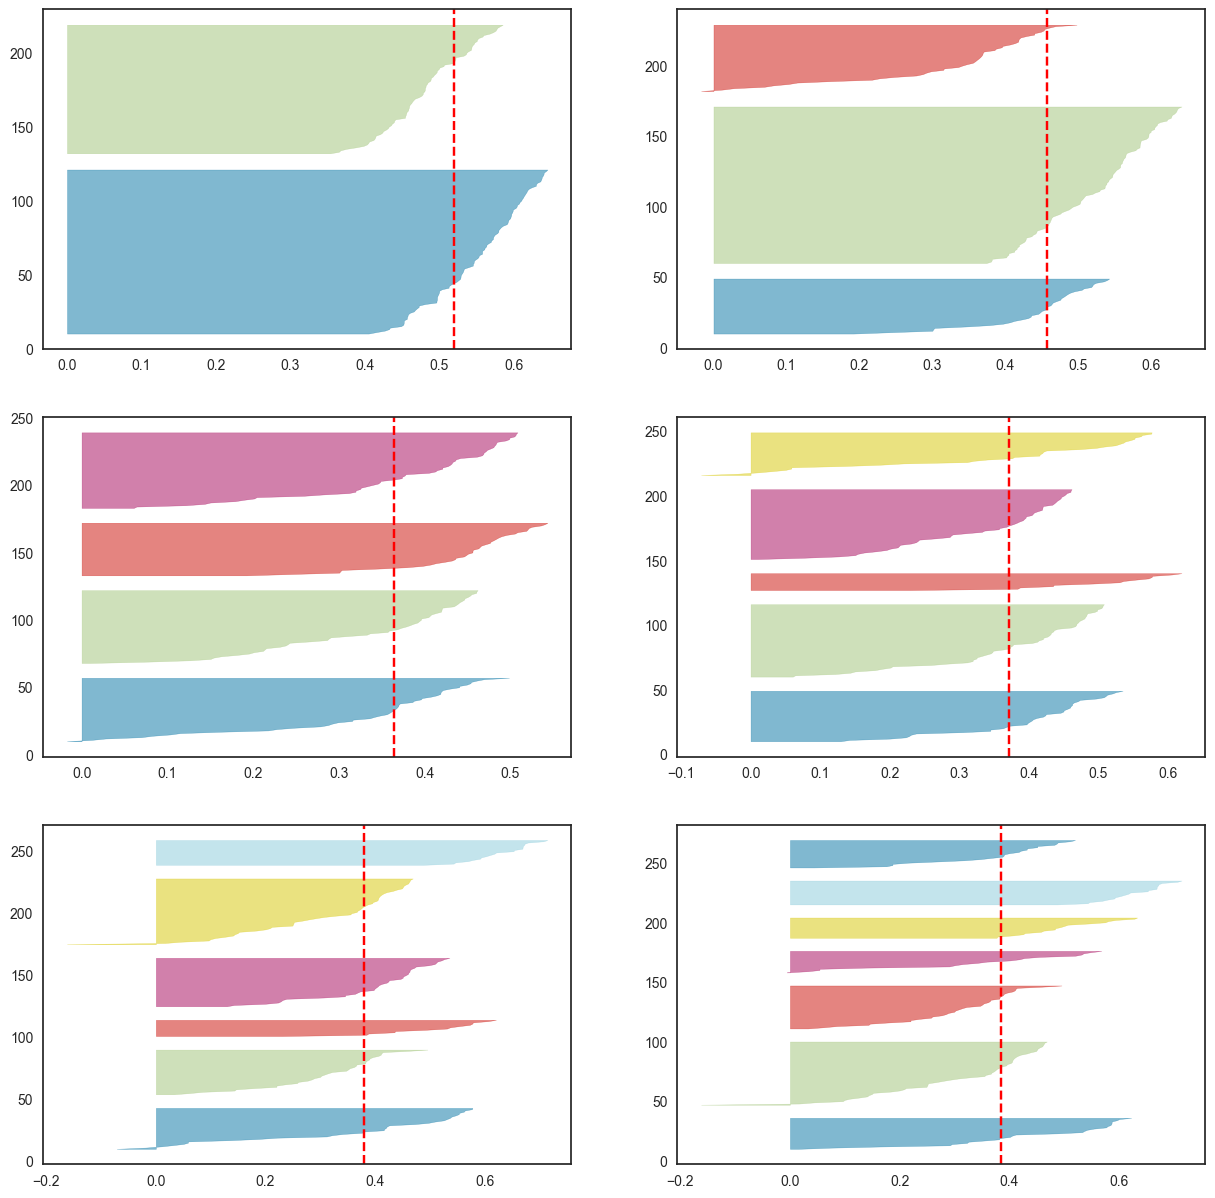

In [50]:
# 실루엣 계수 시각화 2

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i in [2, 3, 4, 5, 6, 7]:
    # k-means 클러스터링 모덜, 생성
    kmeans_model_3 = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=37
    )
    q, mod = divmod(i, 2)
    # 실루엣 계수 시각화
    visualizer = SilhouetteVisualizer(
        kmeans_model_3, colors="yellowbrick", ax=ax[q - 1][mod]
    )
    visualizer.fit(mall_minmax_df)

        Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male  Cluster
0  0.019231            0.000000                0.387755         1.0        0
1  0.057692            0.000000                0.816327         1.0        0
2  0.038462            0.008197                0.051020         0.0        1
3  0.096154            0.008197                0.775510         0.0        1
4  0.250000            0.016393                0.397959         0.0        1


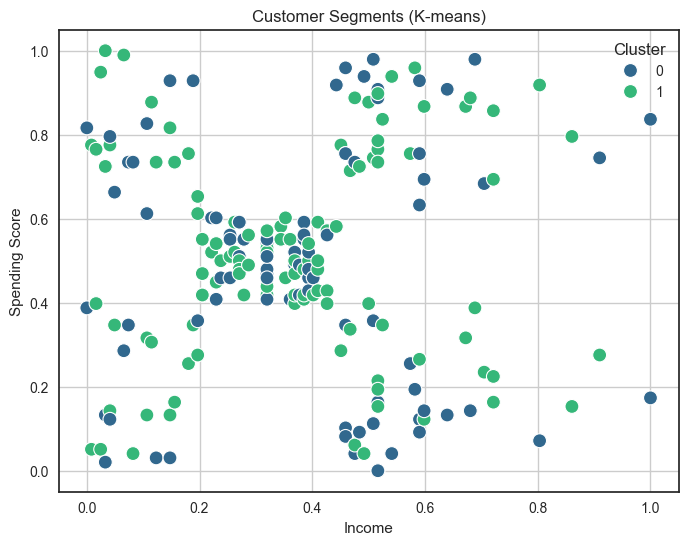

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42).fit(mall_minmax_df)

mall_minmax_cluster_df = mall_minmax_df.copy()
mall_minmax_cluster_df["Cluster"] = kmeans.labels_

print(mall_minmax_cluster_df.head())

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=mall_minmax_cluster_df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",                  # 군집별 색상
    palette="viridis",              # seaborn 지원 컬러맵
    s=100                           # 점 크기
)
plt.title("Customer Segments (K-means)")
plt.xlabel("Income")
plt.ylabel("Spending Score")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

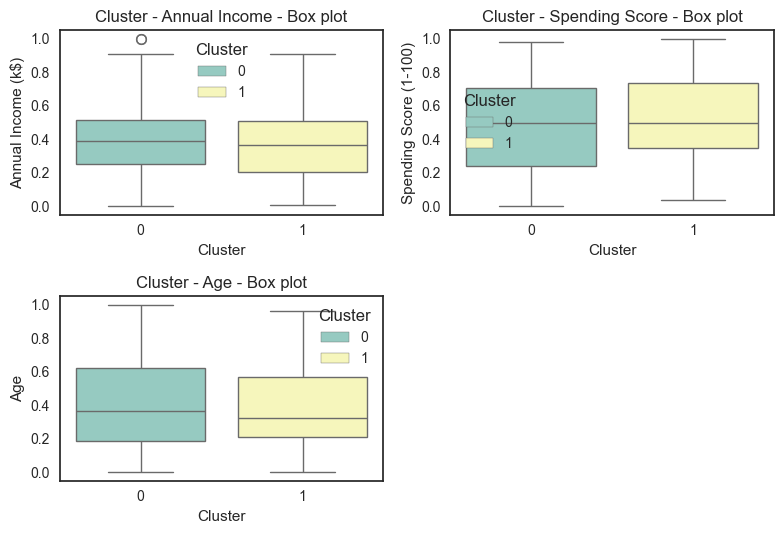

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt


# 소득 - 박스플롯 palette='Set3'
plt.subplot(2, 2, 1)
sns.boxplot(data=mall_minmax_cluster_df, x='Cluster', y='Annual Income (k$)', hue='Cluster', palette='Set3')
plt.legend(title='Cluster')
plt.title('Cluster - Annual Income - Box plot')

# 소비 점수 - 박스플롯
plt.subplot(2, 2, 2)
sns.boxplot(data=mall_minmax_cluster_df, x='Cluster', y='Spending Score (1-100)', hue='Cluster', palette='Set3')
plt.title('Cluster - Spending Score - Box plot')

plt.subplot(2, 2, 3)
sns.boxplot(data=mall_minmax_cluster_df, x='Cluster', y='Age', hue='Cluster', palette='Set3')
plt.title('Cluster - Age - Box plot')


# 출력하기
plt.tight_layout()
plt.show()

## 결론
- 집단 끼리 큰 차이는 없고 성별에 따라서 집단이 나뉘어졌다고 예상할 수 있다.

## 군집화 실습

In [158]:
# 소비 패턴에 따른 군집화를 시켜보자
mall_target_df = mall_minmax_df[
    ["Annual Income (k$)", "Spending Score (1-100)", ]
]  # Input데이터(*모델에 넣어줄 변수들 묶음)로 고객의 수입과 소비 점수만 사용해서 군집화 하기 위
mall_target_df.head()

,Annual Income (k$),Spending Score (1-100)
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959


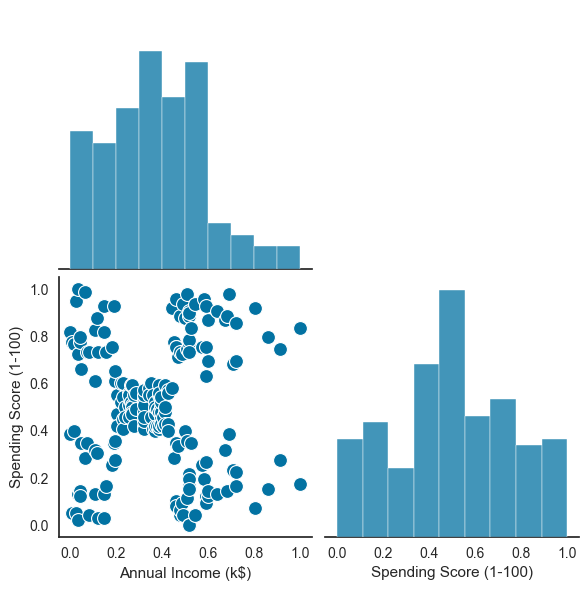

In [159]:
# 어떤 방식으로 고객별로 군집화를 시킬 수 있을 지 확인해보자!

# 산점도 행렬 시각화

# 선 안보이게 설정
sns.set_style("ticks")
# 산점도 그리기, Genre는 컬럼이 없으니까 hue=없음
sns.pairplot(
    mall_target_df,
    corner=True, # 대각선은 분포로 표시
    height=3, # 산점도 크기
    plot_kws={"s": 100}, # 점 크기
)
plt.show()


In [64]:
from sklearn.cluster import KMeans

# k-means 클러스터링 모델 생성
kmeans_model = KMeans(
    init="k-means++", n_clusters=3, n_init=10, max_iter=300, random_state=37
)

kmeans_model.fit(mall_target_df)

# 최저 SSE 값
print(kmeans_model.inertia_)

# 각 군집의 중심점 좌표 확인
print(kmeans_model.cluster_centers_)

# 반복 횟수
print(kmeans_model.n_iter_)

9.058985215159455
[[0.58638083 0.82783883]
 [0.25631369 0.5426549 ]
 [0.46737705 0.1577551 ]]
3


#### K는 몇개 일까요?

<Axes: >

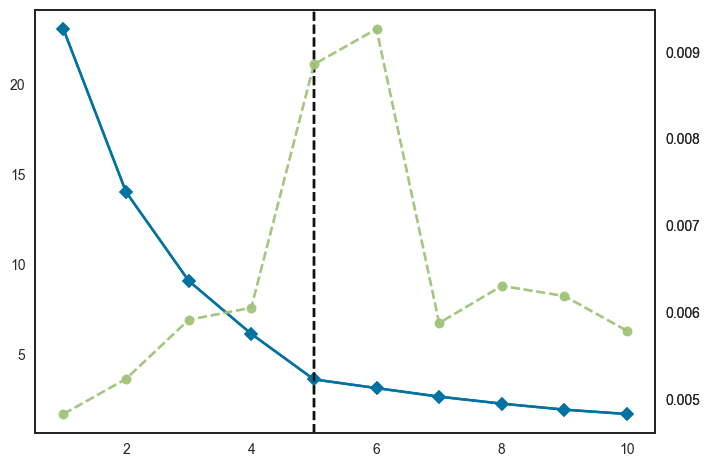

In [65]:
# Elbow Method
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Elbow Chart 그리기
Elbow_Chart = KElbowVisualizer(kmeans_model, k=(1, 11))
Elbow_Chart.fit(mall_target_df)
Elbow_Chart.draw()

   Annual Income (k$)  Spending Score (1-100)  Cluster
0            0.000000                0.387755        4
1            0.000000                0.816327        2
2            0.008197                0.051020        4
3            0.008197                0.775510        2
4            0.016393                0.397959        4


/var/folders/mm/gkm7k5p904x5yzzddzx31myc0000gn/T/ipykernel_20855/701383889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mall_target_df["Cluster"] = kmeans.labels_


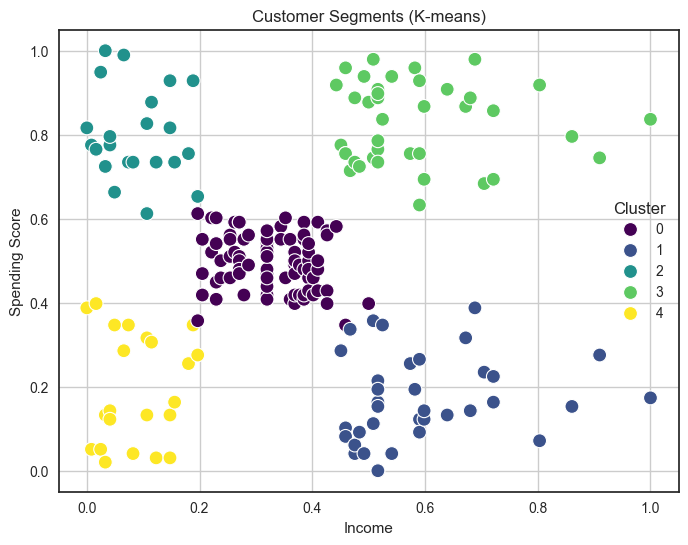

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42).fit(mall_target_df)
mall_target_df["Cluster"] = kmeans.labels_

print(mall_target_df.head())

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=mall_target_df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",                  # 군집별 색상
    palette="viridis",              # seaborn 지원 컬러맵
    s=100                           # 점 크기
)
plt.title("Customer Segments (K-means)")
plt.xlabel("Income")
plt.ylabel("Spending Score")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [68]:
# 실습 과제: 군집화 결과 보고, 군집 별 특성 도출하기

# 각 Cluster 별 평균 특성 출력하기
print(mall_target_df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].agg(['mean', 'min', 'max']))

        Annual Income (k$)                     Spending Score (1-100)  \
                      mean       min       max                   mean   
Cluster                                                                 
0                 0.326958  0.196721  0.500000               0.495339   
1                 0.586381  0.442623  1.000000               0.827839   
2                 0.087928  0.000000  0.196721               0.799629   
3                 0.596311  0.450820  1.000000               0.169218   
4                 0.087928  0.000000  0.196721               0.196197   

                             
              min       max  
Cluster                      
0        0.346939  0.612245  
1        0.632653  0.979592  
2        0.612245  1.000000  
3        0.000000  0.387755  
4        0.020408  0.397959  


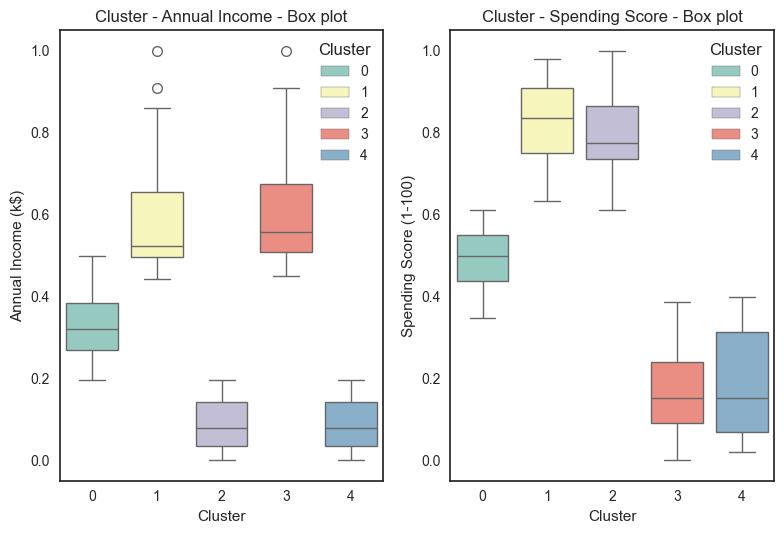

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt


# 소득 - 박스플롯 palette='Set3'
plt.subplot(1, 2, 1)
sns.boxplot(data=mall_target_df, x='Cluster', y='Annual Income (k$)', hue='Cluster', palette='Set3')
plt.legend(title='Cluster')
plt.title('Cluster - Annual Income - Box plot')

# 소비 점수 - 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(data=mall_target_df, x='Cluster', y='Spending Score (1-100)', hue='Cluster', palette='Set3')
plt.title('Cluster - Spending Score - Box plot')


# 출력하기
plt.tight_layout()
plt.show()

## 클러스터 별로 어떤 특성이 있나요?
- 클러스터 0: 중간 수준의 연 소득과 소비 점수를 가진 고객으로, 일반적인 소비 성향을 보이는 중산층 그룹입니다.
- 클러스터 1: 높은 연 소득과 높은 소비 점수를 가진 고객으로, 소득과 소비 모두 활발한 VIP 우수 고객층입니다.
- 클러스터 2: 낮은 연 소득에도 불구하고 소비 점수가 매우 높은 고객으로, 저소득 고소비형, 충동구매나 브랜드 충성도가 높은 고객일 수 있습니다.
- 클러스터 3: 높은 연 소득을 가지고 있으나 소비 점수는 낮은 고객으로, 고소득 저소비형, 절약 지향적이거나 관심이 낮은 고객일 수 있습니다.
- 클러스터 4: 연 소득과 소비 점수 모두 낮은 고객으로, 저소득 저소비형, 마케팅 우선순위가 낮은 그룹입니다.


## 연관성 분석 - 어떤 물건들끼리 연관성이 있는 지 파악해보자!

In [127]:
import pandas as pd

df = pd.read_csv("Groceries_dataset.csv")
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [129]:
# apriori 적용을 위한 품목 리스트 가공


# 사용해야하는 것 drop_duplicates, groupby, apply(list)
# drop_duplicates -> 중복 없애줌
# cust_cd, std_dt, groupby 이후
# prdct_nm을 list로 변환하기 

# 같은 고객, 같은 날에 구매한 품목들 합치고 prcdt_nm컬럼을 리스트로 변환
# groupby 이후 집계를 실시하면 Series로 반환됨

itemset = df.drop_duplicates(
    ['Member_number', 'Date', 'itemDescription']).groupby(
        ['Member_number', 'Date'])['itemDescription'].apply(list)

print(type(itemset))
print(itemset)

<class 'pandas.core.series.Series'>
Member_number  Date      
1000           15-03-2015    [sausage, whole milk, semi-finished bread, yog...
               24-06-2014                    [whole milk, pastry, salty snack]
               24-07-2015                       [canned beer, misc. beverages]
               25-11-2015                          [sausage, hygiene articles]
               27-05-2015                           [soda, pickled vegetables]
                                                   ...                        
4999           24-01-2015    [tropical fruit, berries, other vegetables, yo...
               26-12-2015                               [bottled water, herbs]
5000           09-03-2014                      [fruit/vegetable juice, onions]
               10-02-2015         [soda, root vegetables, semi-finished bread]
               16-11-2014                     [bottled beer, other vegetables]
Name: itemDescription, Length: 14963, dtype: object


In [131]:
# Serie는 드랍이 없어서 DataFrame에 넣고 Member_number, Data 컬럼 제외
itemset= pd.DataFrame(itemset).reset_index().drop(
['Member_number', 'Date'], axis='columns')

print(itemset)

itemset = itemset.squeeze()
itemset

                                         itemDescription
0      [sausage, whole milk, semi-finished bread, yog...
1                      [whole milk, pastry, salty snack]
2                         [canned beer, misc. beverages]
3                            [sausage, hygiene articles]
4                             [soda, pickled vegetables]
...                                                  ...
14958  [tropical fruit, berries, other vegetables, yo...
14959                             [bottled water, herbs]
14960                    [fruit/vegetable juice, onions]
14961       [soda, root vegetables, semi-finished bread]
14962                   [bottled beer, other vegetables]

[14963 rows x 1 columns]


0        [sausage, whole milk, semi-finished bread, yog...
1                        [whole milk, pastry, salty snack]
2                           [canned beer, misc. beverages]
3                              [sausage, hygiene articles]
4                               [soda, pickled vegetables]
                               ...                        
14958    [tropical fruit, berries, other vegetables, yo...
14959                               [bottled water, herbs]
14960                      [fruit/vegetable juice, onions]
14961         [soda, root vegetables, semi-finished bread]
14962                     [bottled beer, other vegetables]
Name: itemDescription, Length: 14963, dtype: object

In [132]:
# value 값의 None 값 지우고 트랜잭션 형태로 바꾸기(전처리단계)
from mlxtend.preprocessing import TransactionEncoder

# encoder도 fit, transform을 해야 함 -> 결과가 arrary로 나옴
te = TransactionEncoder()
te_array = te.fit_transform(itemset)
print(type(te_array))

# 가공을 위해서 컬럼으로 변경
grocery_transaction_df= pd.DataFrame(te_array, columns=te.columns_)

grocery_transaction_df

<class 'numpy.ndarray'>


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 연관성 분석 1
# 지지도가 15% 이상인 빈번항목집합 탐색
from mlxtend.frequent_patterns import apriori

# 최소지지도(min_support) 0.1%인 빈번항목집합 탐색
itemset_apriori = apriori(grocery_transaction_df, min_support=0.001, use_colnames=True)
itemset_apriori

,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.001470,(abrasive cleaner)
3,0.001938,(artif. sweetener)
4,0.008087,(baking powder)
...,...,...
745,0.001136,"(rolls/buns, sausage, whole milk)"
746,0.001002,"(rolls/buns, whole milk, soda)"
747,0.001337,"(rolls/buns, yogurt, whole milk)"
748,0.001069,"(whole milk, sausage, soda)"


In [153]:
# 연관성분석 2
# association_rules 함수 사용해 규칙 파악
from mlxtend.frequent_patterns import association_rules

# 신뢰도가 0.01 이상인 빈번항목집합 탐색
rules = association_rules(itemset_apriori, metric="confidence", min_threshold=0.1,num_itemsets=3)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,1.0,-0.000473,0.975443,-0.184234,0.015130,-0.025175,0.058758
1,(UHT-milk),(whole milk),0.021386,0.157923,0.002540,0.118750,0.751949,1.0,-0.000838,0.955549,-0.252105,0.014367,-0.046519,0.067416
2,(beef),(whole milk),0.033950,0.157923,0.004678,0.137795,0.872548,1.0,-0.000683,0.976656,-0.131343,0.024991,-0.023902,0.083709
3,(berries),(other vegetables),0.021787,0.122101,0.002673,0.122699,1.004899,1.0,0.000013,1.000682,0.004984,0.018930,0.000681,0.072297
4,(berries),(whole milk),0.021787,0.157923,0.002272,0.104294,0.660414,1.0,-0.001168,0.940127,-0.344543,0.012806,-0.063686,0.059341
5,(beverages),(other vegetables),0.016574,0.122101,0.001738,0.104839,0.858622,1.0,-0.000286,0.980716,-0.143419,0.012689,-0.019663,0.059535
6,(beverages),(soda),0.016574,0.097106,0.001871,0.112903,1.162678,1.0,0.000262,1.017808,0.142275,0.016736,0.017496,0.066087
7,(beverages),(whole milk),0.016574,0.157923,0.001938,0.116935,0.740459,1.0,-0.000679,0.953585,-0.262765,0.011232,-0.048674,0.064604
8,(bottled beer),(other vegetables),0.045312,0.122101,0.004678,0.103245,0.845568,1.0,-0.000854,0.978973,-0.160585,0.028747,-0.021479,0.070780
9,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,1.0,-0.000005,0.999874,-0.000702,0.036469,-0.000126,0.101549


In [ ]:
# rules 중에 confidence와 lift가 높은 것들을 뽑아보자
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
129,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,1.0,0.000563,1.131541,0.384877,0.009065,0.116250,0.132562
120,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,1.0,0.000292,1.069304,0.258214,0.007007,0.064813,0.109847
126,"(sausage, soda)",(whole milk),0.005948,0.157923,0.001069,0.179775,1.138374,1.0,0.000130,1.026642,0.122281,0.006568,0.025951,0.093273
99,(semi-finished bread),(whole milk),0.009490,0.157923,0.001671,0.176056,1.114825,1.0,0.000172,1.022008,0.103985,0.010081,0.021534,0.093318
123,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,1.0,0.000102,1.015701,0.076751,0.008130,0.015459,0.089702
127,"(whole milk, sausage)",(yogurt),0.008955,0.085879,0.001470,0.164179,1.911760,1.0,0.000701,1.093681,0.481231,0.015748,0.085657,0.090650
30,(detergent),(whole milk),0.008621,0.157923,0.001403,0.162791,1.030824,1.0,0.000042,1.005814,0.030162,0.008499,0.005781,0.085839
46,(ham),(whole milk),0.017109,0.157923,0.002740,0.160156,1.014142,1.0,0.000038,1.002659,0.014188,0.015904,0.002652,0.088754
9,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,1.0,-0.000005,0.999874,-0.000702,0.036469,-0.000126,0.101549
37,(frozen fish),(whole milk),0.006817,0.157923,0.001069,0.156863,0.993287,1.0,-0.000007,0.998743,-0.006759,0.006533,-0.001259,0.081817


In [160]:
# 연관성 분석 3

# association_rules 함수 사용해 lift가 1이상 파악
lift_rules = association_rules(itemset_apriori, metric="lift", min_threshold=1.5)
lift_rules.sort_values(['confidence', 'lift'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
14,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,1.0,0.000563,1.131541,0.384877,0.009065,0.116250,0.132562
12,"(whole milk, sausage)",(yogurt),0.008955,0.085879,0.001470,0.164179,1.911760,1.0,0.000701,1.093681,0.481231,0.015748,0.085657,0.090650
13,"(whole milk, yogurt)",(sausage),0.011161,0.060349,0.001470,0.131737,2.182917,1.0,0.000797,1.082219,0.548014,0.020992,0.075973,0.078050
5,(flour),(tropical fruit),0.009757,0.067767,0.001069,0.109589,1.617141,1.0,0.000408,1.046969,0.385385,0.013986,0.044862,0.062684
9,(processed cheese),(root vegetables),0.010158,0.069572,0.001069,0.105263,1.513019,1.0,0.000363,1.039891,0.342549,0.013594,0.038360,0.060316
0,(beverages),(sausage),0.016574,0.060349,0.001537,0.092742,1.536764,1.0,0.000537,1.035704,0.355168,0.020390,0.034474,0.059106
10,"(whole milk, soda)",(sausage),0.011629,0.060349,0.001069,0.091954,1.523708,1.0,0.000368,1.034806,0.347750,0.015080,0.033635,0.054836
3,(specialty chocolate),(citrus fruit),0.015973,0.053131,0.001403,0.087866,1.653762,1.0,0.000555,1.038081,0.401735,0.020731,0.036684,0.057141
6,(napkins),(pastry),0.022121,0.051728,0.001738,0.078550,1.518529,1.0,0.000593,1.029109,0.349192,0.024096,0.028285,0.056071
7,(pastry),(napkins),0.051728,0.022121,0.001738,0.033592,1.518529,1.0,0.000593,1.011869,0.360095,0.024096,0.011730,0.056071


# 실습 과제: 최종 도출된 결과 상위 3개 규칙 해석하기 

- 규칙 5번(예시) : flour와 tropicola fruit를 동시에 구매한 고객이 약 0.1069%, 그 중 A를 구매한 고객이 flour와 tropicola fruit를 구매한 고객의 약 10%, flour를 구매할 확률보다 flour와 tropicola fruit를 구매할 확률이 1.6배 높음 

- 규칙 14번: sausage와 yogurt를 동시에 구매한 고객은 전체의 약 0.5748%, 그 중 **약 25.6%**가 whole milk를 추가로 구매함 whole milk의 단독 구매 확률보다 sausage + yogurt와 함께 구매할 확률이 1.62배 높음
- 규칙 12번: whole milk와 sausage를 동시에 구매한 고객은 전체의 약 0.8955%, 그 중 **약 16.4%**가 yogurt를 추가로 구매함 yogurt의 단독 구매 확률보다 whole milk + sausage와 함께 구매할 확률이 1.91배 높음
- 규칙 13번: whole milk와 yogurt를 동시에 구매한 고객은 전체의 약 1.1161%, 그 중 **약 13.17%**가 sausage를 추가로 구매함 sausage의 단독 구매 확률보다 whole milk + yogurt와 함께 구매할 확률이 2.18배 높음